
원본데이터 - 로그데이터

원본데이터  - 유저 특성 데이터 - 클러스터링 이후에 결과 집단의 특성을 토대로 비즈니스 전략 수립 가능


            - 비즈니스 전략 데이터


1. 유저 분석을 위한 유저 기준으로 정리된 데이터 - 클러스터링
=> 유저특성지표

row의 단위 : 유저 1명
col의 단위 : 해당 유저에 대한 통계량

EDA해서 나온 요소들을 통합하기

	1) R, F, M
	2) 구매횟수대비 쿠폰사용율
  	3) 평균구매주기






2. 마케팅, 비즈니스 전략을 위한 데이터
=> 경향성 지표


	1) ROAS 지표 = 광고비 대비 매출액(수익)
	   단위기간 중 총 광고비용이 높은 특정 기간
      	   특정 기간 중에 거래량이 많은 집단 특정
	   전략 : 1)결과값을 보고 저희 주관이 들어간 요소

	2) 오프라인 비용으로부터 초래되는 비효율 줄이기
                주장 : 오프라인 마케팅이 효과가 미비하다
                         효과가 상대적으로 좋은 온라인이 오프라인에 맞춰서 조정되는 것이 비효율이다
	   
                오프라인비용 : 일주일단위로 조정 - 비탄력적 요소
                온라인비용 : 하루 단위로 조정 - 탄력적 요소

	    온라인, 오프라인 7일 이동평균 상관관계 = 0.74

	   총 마케팅비용과 총매출 간의 관계        = 0.14
                온라인비용이동평균과 총매출간의 관계 = 0.2












목표1. 클러스터링 해보기
그것을 위한 숙제
1. RFM 간소화하기(클러스터링과의 비교군) => 7개 그룹정도?
    5 * 5 * 2 = 
    - 참고 및 평가요소(+ 실루엣 점수)
    1) 클러스터링을 통해 나온 그룹을 어떤 그룹으로 정의할지의 참고사항
    2) 우리만의 클러스터링이 가지고 있는 요소(ex. 우리가 한 클러스터링의 vip는 ㅇㅇㅇ가 RFM에 비해 높다, 대신 ㅇㅇㅇ는 관대하다)
    분류된 고객층 중에서 특정층을 공략하기 => 최종목표
2. Monetary별 가중치 해결하기
3. EDA를 통한 유저 특성 컬럼 추가하기


목표2. ROAS에 요소 추가



## 2023-04-09
### 1. rfm의 컬럼 기준으로 EDA
        - 컬럼들의 분포를 기준으로 bins값을 다시 정한다든지 등

### 2. rfm의 카테고리 컬럼의 차원 축소
        - 최다구매카테고리 : 당일에 결정
        - 지역 : 5개
        - 최다구매월 : 분기로 축소
        - 성별 : 2개

### 3. 클러스터링
        - 적절한 클러스터링 기법과 클러스터의 수, 각 센터로이드의 특징

## 클러스터링을 강화하는 방향
### 1. 유저 중심 컬럼

In [26]:
import numpy as np
import pandas as pd

import datetime as dt
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import re

import warnings
warnings.filterwarnings('ignore')

In [27]:
df1 = pd.read_csv('open/Onlinesales_info.csv')
df2 = pd.read_csv('open/Customer_info.csv')
df3 = pd.read_csv('open/Discount_info.csv')
df4 = pd.read_csv('open/Marketing_info.csv')
df5 = pd.read_csv('open/Tax_info.csv')

In [28]:
df = pd.merge(df1, df2, how='left', on='고객ID')
df = pd.merge(df, df5, how='left', on='제품카테고리')

df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['월'] = df['거래날짜'].dt.month

In [29]:
def month_shift(x):
    dict = {1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'}
    
    return dict[x]

In [30]:
df['월'] = df['월'].apply(month_shift)

In [31]:
df = pd.merge(df, df3, how='left', on=['월', '제품카테고리'])

In [32]:
df4['날짜'] = pd.to_datetime(df4['날짜'])
df = pd.merge(df, df4, how='left', left_on='거래날짜', right_on='날짜')

df = df.drop('날짜', axis=1)

In [33]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5  
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5  
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5

In [34]:
df.to_csv('merge.csv')

In [35]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5  
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5  
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5  
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5

In [36]:
user_region = pd.DataFrame(df.groupby('고객ID')['고객지역'].apply(lambda x: x.value_counts().idxmax()))

In [37]:
mode_category = pd.DataFrame(df.groupby('고객ID')['제품카테고리'].apply(lambda x: x.value_counts().idxmax()))

In [38]:
df['쿠폰코드'] = df['쿠폰코드'].fillna(np.nan)
df['할인율'] = df['할인율'].fillna(0)

In [39]:
def true_discount(x):
    if x == 'Used':
        return 1
    else:
        return 0

In [40]:
df['true_discount'] = df['쿠폰상태'].apply(true_discount)

In [41]:
df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별     고객지역  가입기간   GST    월    쿠폰코드   할인율  오프라인비용   온라인비용  \
0  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
1  6.5      Used  남  Chicago    12  0.10  Jan  ELEC10  10.0    4500  2424.5   
2  6.5      Used  남  Chicago    12  0.10  Jan   OFF10  10.0    4500  2424.5   
3  6.5  Not Used  남  Chicago    12  0.18  Jan  SALE10  10.0    4500  2424.5   
4  6.5      Used  남  Chicago    12  0.18  Jan   AIO10  10.0    4500  2424.5   

   true_discount  
0              1  
1              1  
2              1  
3              0  
4              1

거래ID	     - F(count)
거래날짜     - 기준(날짜별 금액), 고유거래일(nunique)
제품ID	    - 
제품카테고리 - 최다구매카테고리
수량        - 평균수량
평균금액    - 수량, 할인율, GST 배송료 등과 결합하여 총금액
배송료	    - (총금액 계산을 위한 평균 배송료)
쿠폰상태    - 구매횟수대비쿠폰사용율, 총할인금액, clicked 비율
성별	    - 성별은 성별
고객지역	- 지역은 지역
가입기간	- 기간은 기간
GST	       - 총납세액
월	       - 최다구매월, 해당월의 거래수
할인율	    - 총금액 계산시에 사용, 평균 할인율(not used = 0)

4개씩 분담해서 만들어오기

### 1. raw 데이터 join만 해놓은   df                                
                    
- ~~총금액(row단위) ~~                        
- ~~(총금액 계산을 위한 평균 배송료)  ~~      
- ~~납세액(row)~~

### 2. user별로 groupby한 rfm
- ~~F(count)~~
- 고유거래일(nunique)
- ~~최다구매카테고리~~    
- 평균수량 
- ~~총금액(유저단위)~~
- ~~구매횟수대비쿠폰사용율~~
- 총할인금액
- clicked 비율
- 성별, 지역, 기간
- ~~총납세액(유저단위)~~
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)



1) 준범                                                               
- 총금액(유저단위)                     
- 총금액(row단위)                    
- 납세액(row)                           
- (총금액 계산을 위한 평균 배송료)        
- 총납세액(유저단위)

2) 정식

- 고유거래일(nunique)
- 평균수량 

3) 서인
- 총할인금액
- clicked 비율
- 성별, 지역, 기간

4) 경화
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)

In [42]:
transfer = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['배송료'].mean() / df.groupby(['고객ID', '거래ID'])['제품카테고리'].count())
transfer = transfer.reset_index()
transfer = transfer.rename(columns={0:'평균배송료'})


In [43]:
df = pd.merge(df, transfer, how='left', on=['고객ID', '거래ID'])

In [44]:
df['납세액'] = df['수량'] * df['평균금액'] * df['GST']

In [45]:
df['총금액'] = (df['평균금액'] * ((100 - (df['true_discount'] * df['할인율'])) / 100) * df['수량']) + df['평균배송료'] + df['납세액']  # 고객이 최종적으로 부담하는 금액


In [60]:
today_date = dt.datetime(2019,12,31)
rfm = pd.DataFrame(df.groupby('고객ID').agg({'거래ID':'nunique',
                          '총금액':'sum',
                          '거래날짜': lambda x: (today_date - x.max()).days,
                          '납세액':'sum'}))

rfm = rfm.rename(columns={'거래ID':'Frequency',
                          '총금액':'Monetary',
                          '거래날짜':'Recency',
                          '납세액':'총납세액'})
rfm = rfm[['Recency', 'Frequency', 'Monetary', '총납세액']]

In [61]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1468 entries, USER_0000 to USER_1467
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    1468 non-null   int64  
 1   Frequency  1468 non-null   int64  
 2   Monetary   1468 non-null   float64
 3   총납세액       1468 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 57.3+ KB


In [62]:
rfm.head()

Recency  Frequency    Monetary       총납세액
고객ID                                                
USER_0000      107          1    101.3912     4.6982
USER_0001       59         31  15407.7190  2067.9070
USER_0002       73          8   1596.0858   203.6008
USER_0003       17         11   1438.5072   148.2642
USER_0004      107         13   1541.9718   151.7598

In [63]:
temp = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['수량'].sum()).reset_index()

mean_purchase_quantity = temp.groupby('고객ID')['수량'].mean().reset_index()
# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, mean_purchase_quantity, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'수량': '평균구매수량'}, inplace=True)
rfm.head()

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량
0  USER_0000      107          1    101.3912     4.6982   3.000000
1  USER_0001       59         31  15407.7190  2067.9070  11.032258
2  USER_0002       73          8   1596.0858   203.6008  26.125000
3  USER_0003       17         11   1438.5072   148.2642   1.909091
4  USER_0004      107         13   1541.9718   151.7598   4.307692

In [64]:
kh_mon = df.groupby(['고객ID', '월'])['거래ID'].nunique().reset_index(name='구매횟수')
kh_mon = kh_mon.loc[kh_mon.groupby('고객ID')['구매횟수'].idxmax()]
kh_mon = kh_mon.rename(columns={'월':'최다구매월'})


df['real_discount'] = df['할인율'] * df['true_discount']
dis_kh = df.groupby('고객ID')['real_discount'].mean().reset_index()
dis_kh['real_discount'] = dis_kh['real_discount'].round(2)
dis_kh = dis_kh.rename(columns={'real_discount':'평균할인율'})

rfm= pd.merge(rfm,kh_mon, how='left',on='고객ID')
rfm= pd.merge(rfm,dis_kh, how='left',on='고객ID')
rfm

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0     USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1     USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2     USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3     USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4     USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   
...         ...      ...        ...         ...        ...        ...   ...   
1463  USER_1463      270          3    678.7202    51.2202  15.333333   Apr   
1464  USER_1464       87         19   2631.9586   277.1706   7.421053   Aug   
1465  USER_1465      194          2    128.5234    18.0264   5.000000   Apr   
1466  USER_1466       69          1    333.8000    29.8000   2.000000   Oct   
1467  USER_1467       82         53   7000.0783   583.1923   2.924528   Oct   

      구매횟수  평균할인율  
0        1  30.00  
1       18   8.00  
2        4  11.74  
3       11  10.59  
4       13   9.17  
...    ...    ...  
1463     3   4.29  
1464    10   9.25  
1465     1   3.75  
1466     1   0.00  
1467    31   3.73  

[1468 rows x 9 columns]

In [65]:
unique_transaction_date = df.groupby('고객ID')['거래날짜'].nunique()

# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, unique_transaction_date, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'거래날짜': '고유거래일수'}, inplace=True)
rfm.head()

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0  USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1  USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2  USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3  USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4  USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   

   구매횟수  평균할인율  고유거래일수  
0     1  30.00       1  
1    18   8.00       3  
2     4  11.74       2  
3    11  10.59       1  
4    13   9.17       1

In [66]:
last_date = dt.datetime(2019, 12, 31)

date = df.sort_values(['고객ID', '거래날짜'])[['고객ID', '거래날짜']].drop_duplicates()
date['구매주기'] = date.groupby('고객ID')['거래날짜'].diff().fillna(last_date-date['거래날짜'])

avg_buying = pd.DataFrame(date.groupby('고객ID')['구매주기'].mean()).reset_index()


rfm = pd.merge(rfm, avg_buying, how='left', on='고객ID').rename(columns={'구매주기':'평균구매주기'})

rfm['평균구매주기'] = rfm['평균구매주기'].dt.days

In [67]:
# 클러스터링에 사용할 유저 특성 테이블
rfm = pd.merge(rfm, mode_category, how='left', on='고객ID')

In [68]:
rfm = rfm.rename(columns={'제품카테고리':'최다구매카테고리',
                          '구매횟수':'당월구매횟수'})
rfm

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0     USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1     USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2     USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3     USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4     USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   
...         ...      ...        ...         ...        ...        ...   ...   
1463  USER_1463      270          3    678.7202    51.2202  15.333333   Apr   
1464  USER_1464       87         19   2631.9586   277.1706   7.421053   Aug   
1465  USER_1465      194          2    128.5234    18.0264   5.000000   Apr   
1466  USER_1466       69          1    333.8000    29.8000   2.000000   Oct   
1467  USER_1467       82         53   7000.0783   583.1923   2.924528   Oct   

      당월구매횟수  평균할인율  고유거래일수  평균구매주기  최다구매카테고리  
0          1  30.00       1     107   Apparel  
1         18   8.00       3     168  Nest-USA  
2          4  11.74       2     155    Office  
3         11  10.59       1      17   Apparel  
4         13   9.17       1     107   Apparel  
...      ...    ...     ...     ...       ...  
1463       3   4.29       1     270   Apparel  
1464      10   9.25       3      99   Apparel  
1465       1   3.75       2     173   Apparel  
1466       1   0.00       1      69  Nest-USA  
1467      31   3.73       2     114   Apparel  

[1468 rows x 12 columns]

In [69]:

df_1=pd.DataFrame(data=df,columns=['고객ID','성별','고객지역','가입기간'])
df_1=df_1.drop_duplicates()
df_1=df_1.reset_index(drop=True)
rfm=pd.merge(rfm,df_1,on='고객ID')

df['df총할인금액']=df['수량']*df['평균금액']*df['true_discount']*(0.01*df['할인율'])
for_rfm=df.groupby('고객ID')['df총할인금액'].sum()
for_rfm=pd.DataFrame(for_rfm)
rfm=pd.merge(rfm,for_rfm,on='고객ID')
rfm.head(10)

clicked = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())
clicked_core = pd.DataFrame(clicked.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Clicked'), :].sort_index())
rfm=pd.merge(rfm,clicked_core,on='고객ID', how='left').fillna(0).rename(columns={'df총할인금액':'총할인금액', '쿠폰상태':'Clicked_ratio'})

In [70]:
coupon = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())

coupon_core = pd.DataFrame(coupon.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Used'), :].sort_index())


rfm = pd.merge(rfm, coupon_core, how='left', on='고객ID').fillna(0)
rfm = rfm.rename(columns={'쿠폰상태':'Used_ratio'})

In [71]:
rfm['Used_ratio_per_F'] = rfm['Used_ratio'] / rfm['Frequency']
rfm['Clicked_ratio_per_F'] = rfm['Clicked_ratio'] / rfm['Frequency']

In [72]:
rfm.columns

Index(['고객ID', 'Recency', 'Frequency', 'Monetary', '총납세액', '평균구매수량', '최다구매월',
       '당월구매횟수', '평균할인율', '고유거래일수', '평균구매주기', '최다구매카테고리', '성별', '고객지역', '가입기간',
       '총할인금액', 'Clicked_ratio', 'Used_ratio', 'Used_ratio_per_F',
       'Clicked_ratio_per_F'],
      dtype='object')

In [73]:
rfm['최다구매카테고리'].unique()

array(['Apparel', 'Nest-USA', 'Office', 'Nest', 'Headgear', 'Lifestyle',
       'Drinkware', 'Notebooks & Journals', 'Bags', 'Waze', 'Accessories',
       'Bottles'], dtype=object)

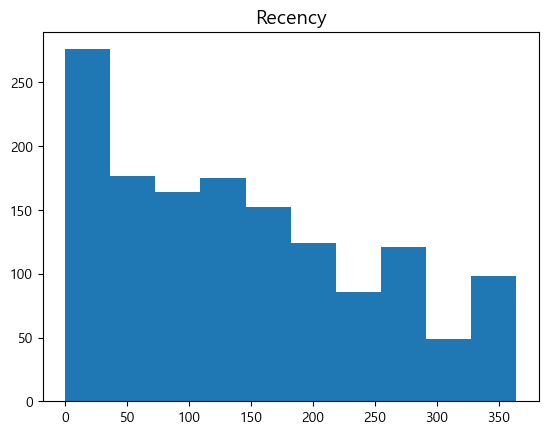

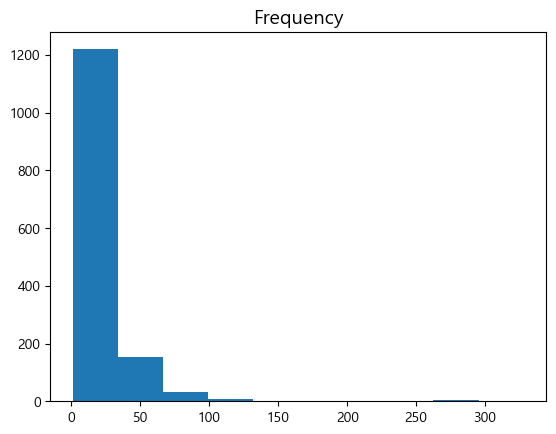

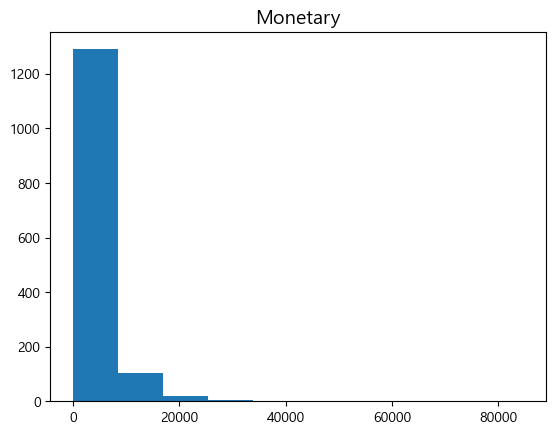

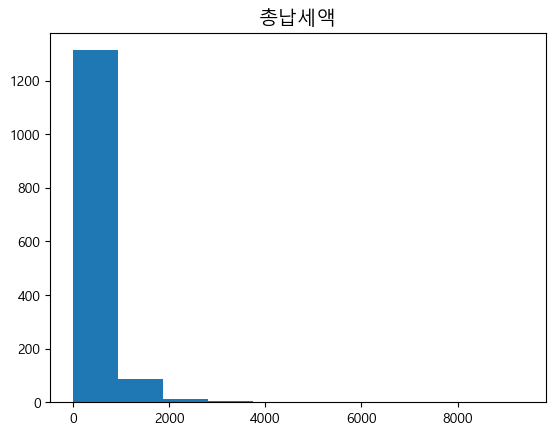

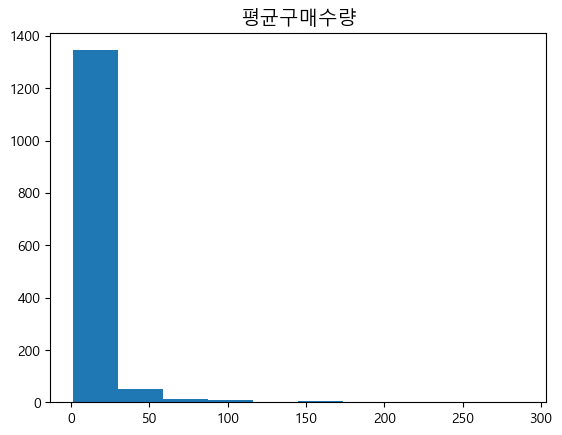

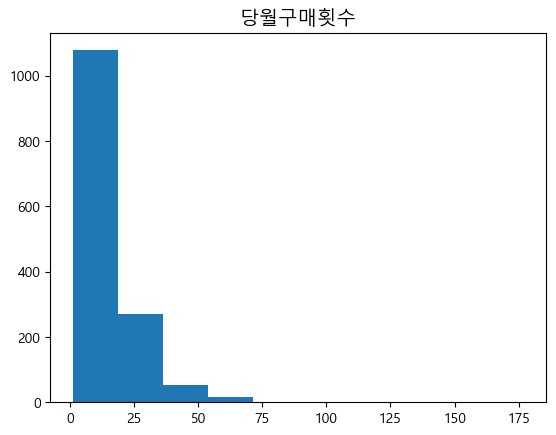

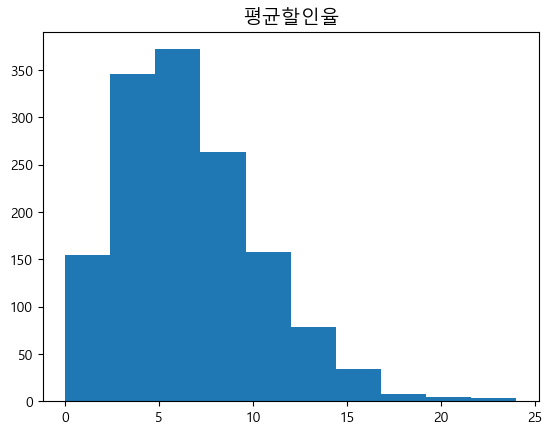

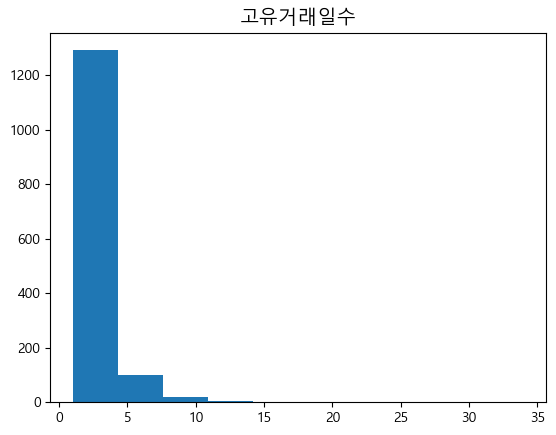

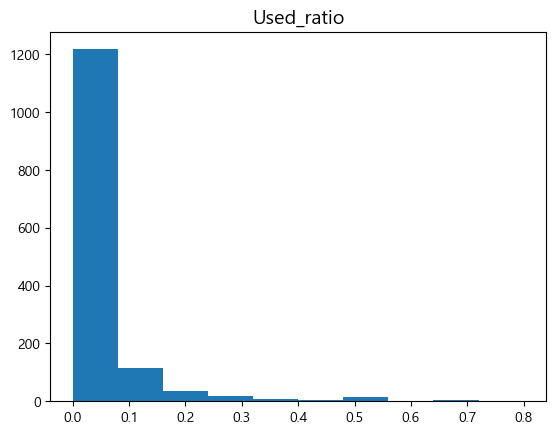

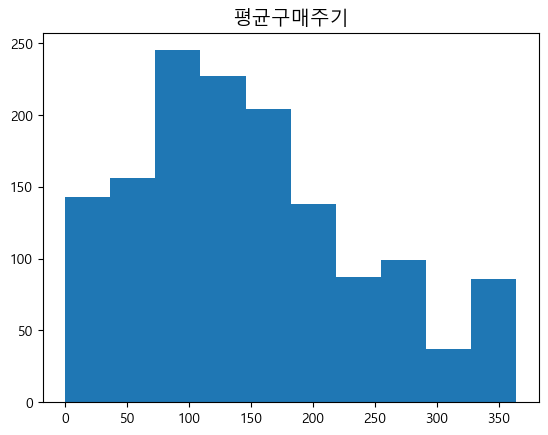

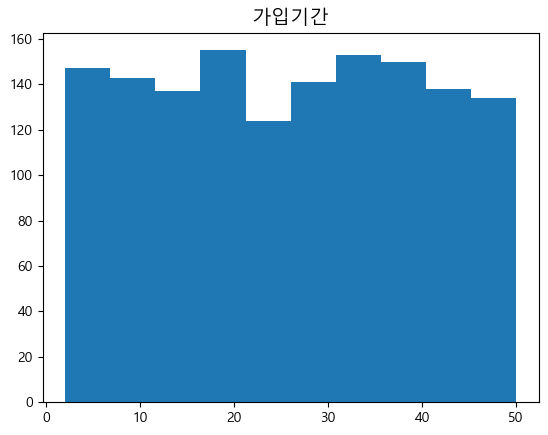

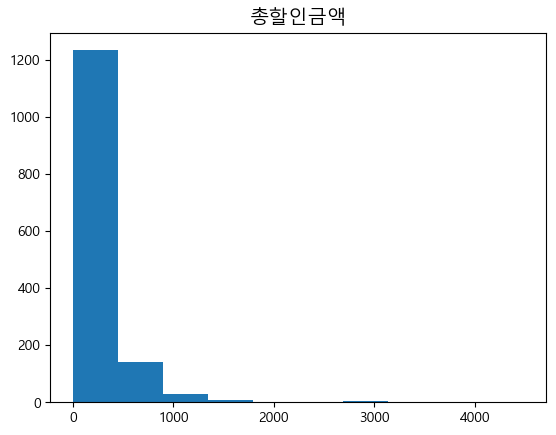

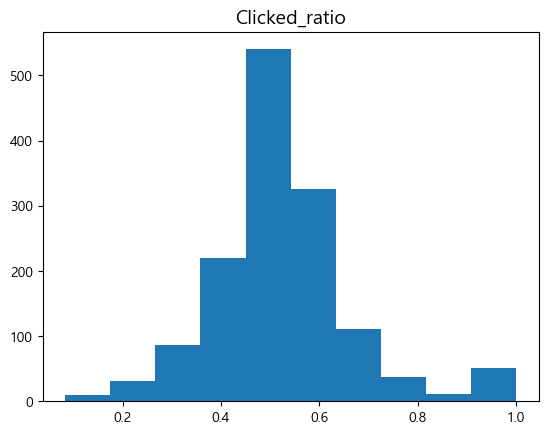

In [69]:
for col in rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','Used_ratio','평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio']].columns:
    plt.hist(rfm[col])
    plt.title(col, fontsize=14)
    plt.show()

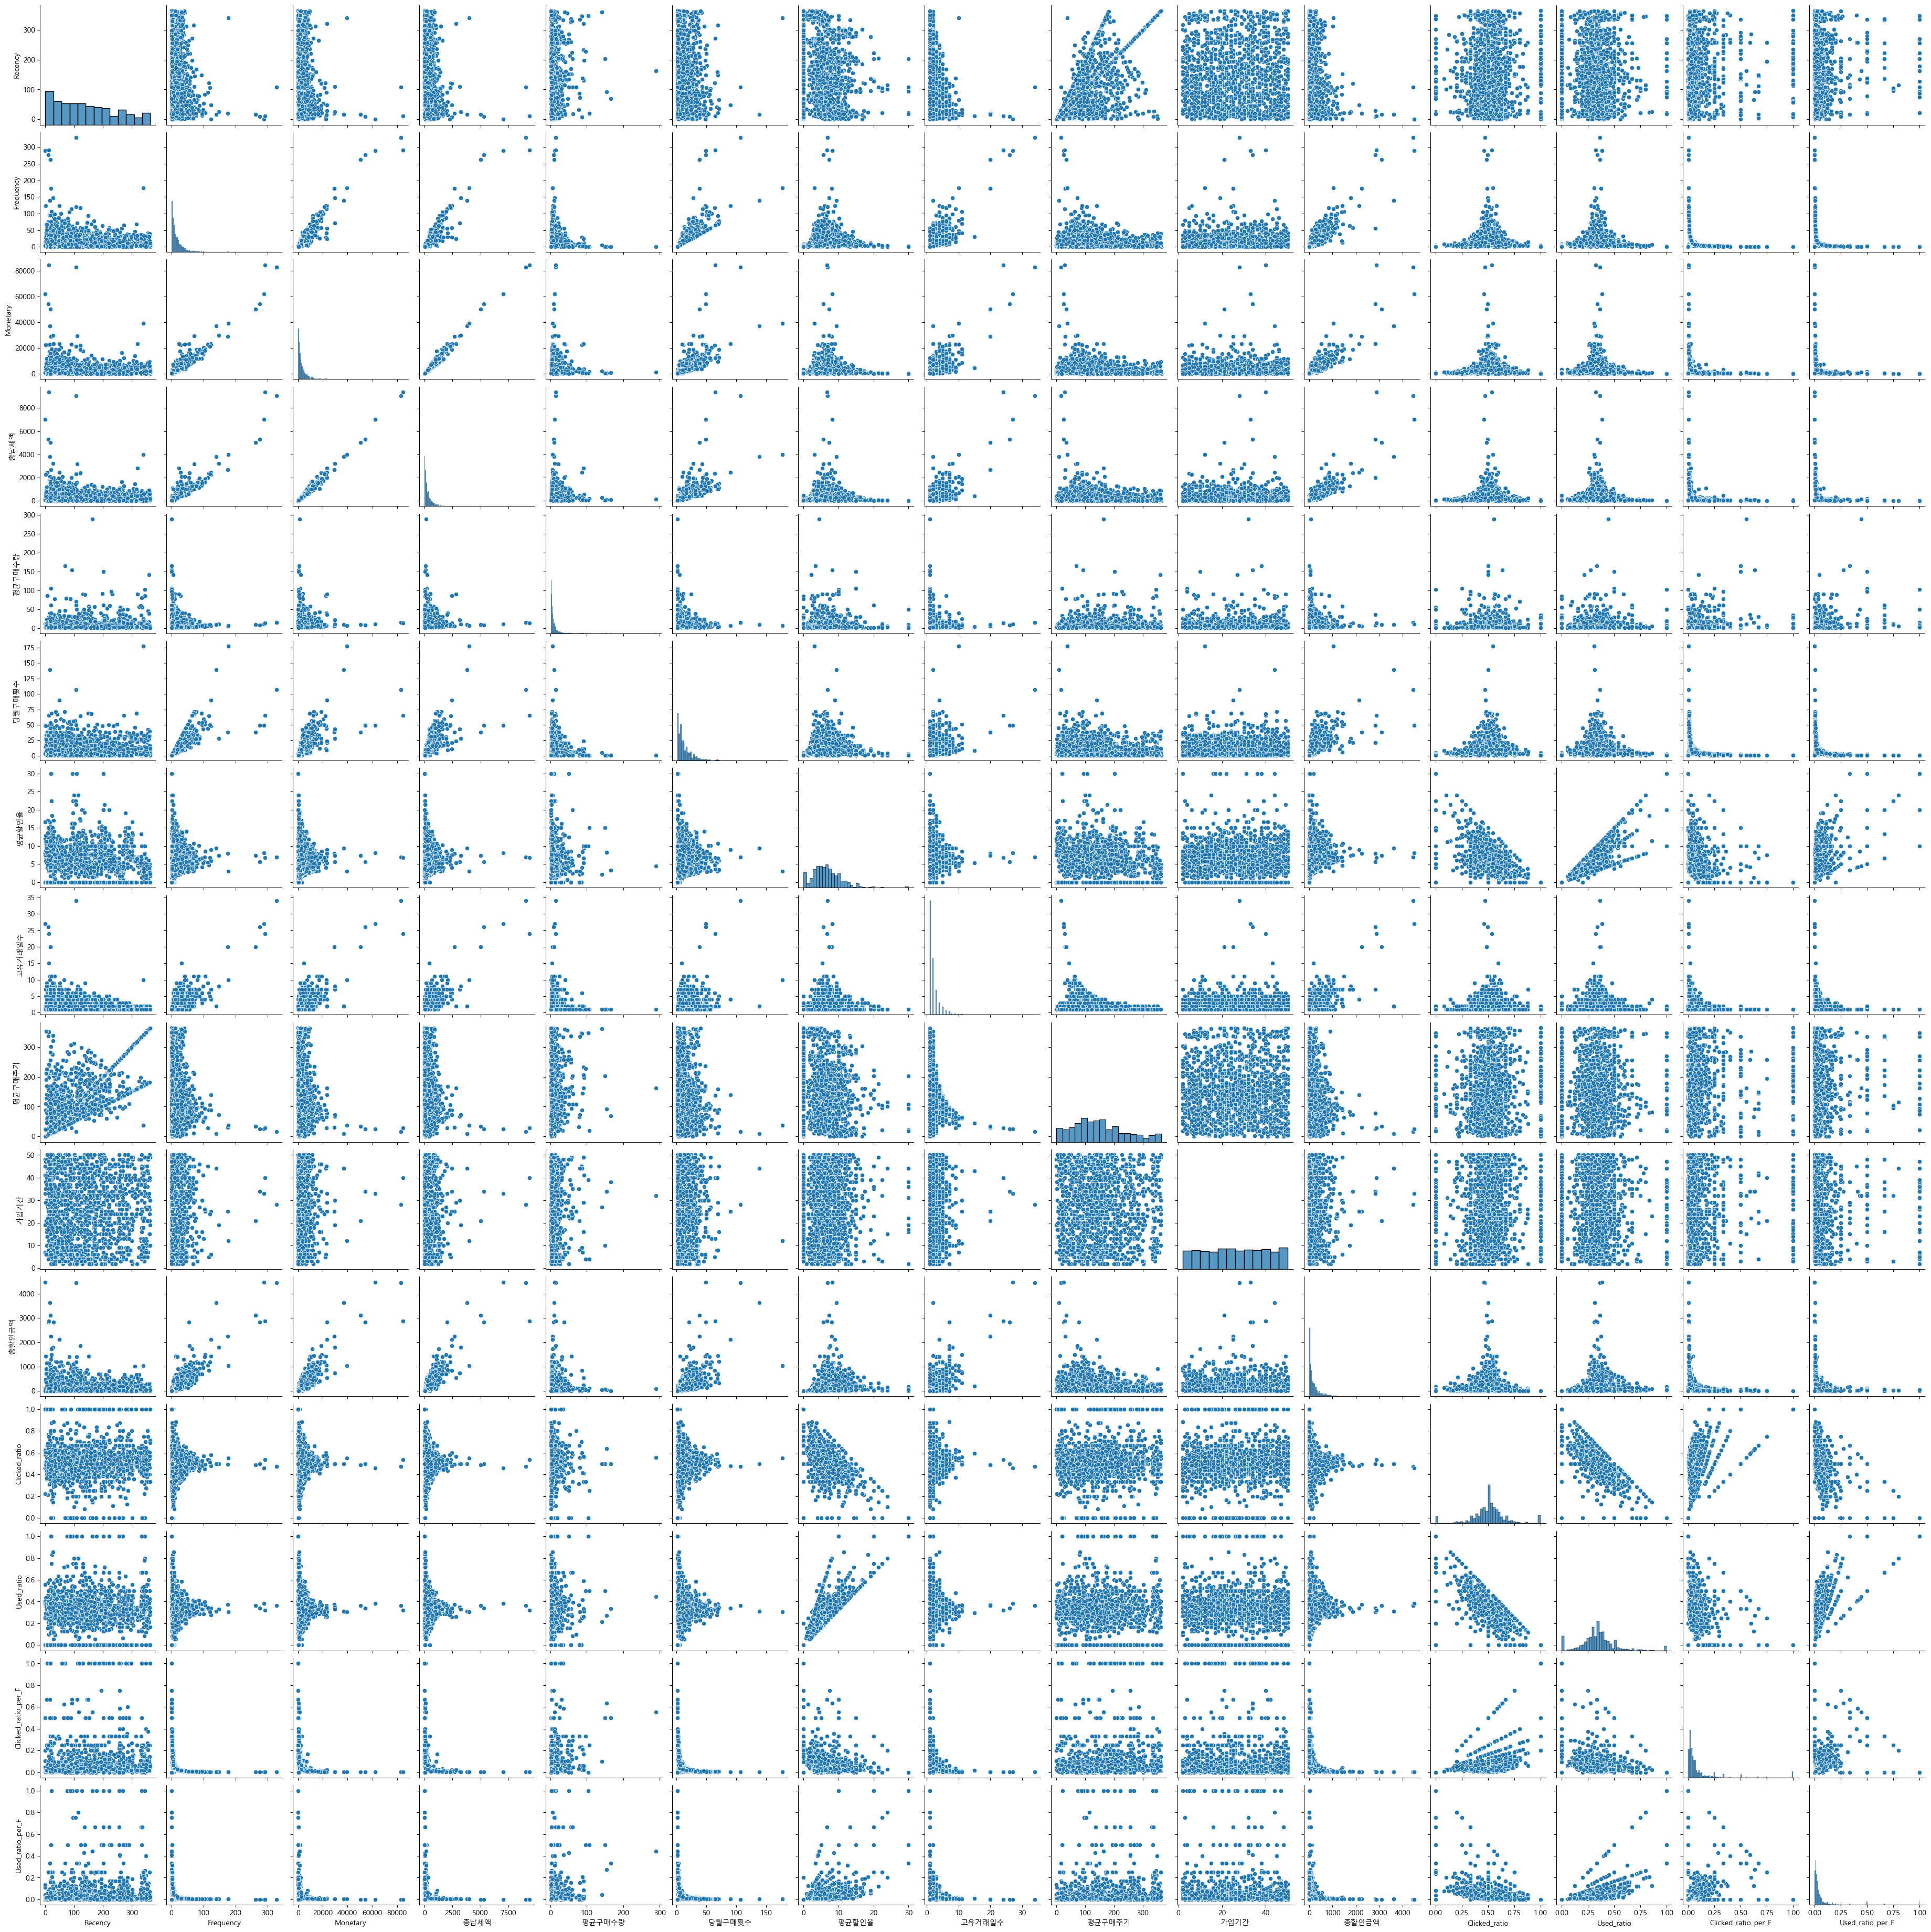

In [76]:
sns.pairplot(rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio','Used_ratio', 'Clicked_ratio_per_F','Used_ratio_per_F']])

In [74]:
core = rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','평균구매주기', '가입기간', '총할인금액', 'Clicked_ratio','Used_ratio', 'Clicked_ratio_per_F','Used_ratio_per_F']].corr(method='pearson', min_periods=1)

In [75]:
for i in core.index:
    display(pd.DataFrame(core.loc[i, :]))

Recency
Recency              1.000000
Frequency           -0.218934
Monetary            -0.204182
총납세액                -0.176565
평균구매수량               0.059750
당월구매횟수              -0.109909
평균할인율               -0.179300
고유거래일수              -0.301409
평균구매주기               0.762261
가입기간                 0.022597
총할인금액               -0.261245
Clicked_ratio        0.005457
Used_ratio          -0.010367
Clicked_ratio_per_F  0.146239
Used_ratio_per_F     0.126459

Frequency
Recency              -0.218934
Frequency             1.000000
Monetary              0.949483
총납세액                  0.934530
평균구매수량               -0.029558
당월구매횟수                0.780587
평균할인율                -0.003628
고유거래일수                0.770677
평균구매주기               -0.228328
가입기간                  0.009821
총할인금액                 0.871212
Clicked_ratio        -0.000363
Used_ratio           -0.002992
Clicked_ratio_per_F  -0.288763
Used_ratio_per_F     -0.236846

Monetary
Recency             -0.204182
Frequency            0.949483
Monetary             1.000000
총납세액                 0.991906
평균구매수량               0.062289
당월구매횟수               0.725124
평균할인율               -0.018136
고유거래일수               0.751528
평균구매주기              -0.210503
가입기간                 0.017448
총할인금액                0.880622
Clicked_ratio        0.001487
Used_ratio          -0.008843
Clicked_ratio_per_F -0.254193
Used_ratio_per_F    -0.209667

총납세액
Recency             -0.176565
Frequency            0.934530
Monetary             0.991906
총납세액                 1.000000
평균구매수량               0.082382
당월구매횟수               0.698204
평균할인율               -0.010935
고유거래일수               0.748467
평균구매주기              -0.190564
가입기간                 0.017733
총할인금액                0.873834
Clicked_ratio       -0.000734
Used_ratio          -0.005600
Clicked_ratio_per_F -0.241954
Used_ratio_per_F    -0.199179

평균구매수량
Recency              0.059750
Frequency           -0.029558
Monetary             0.062289
총납세액                 0.082382
평균구매수량               1.000000
당월구매횟수              -0.050261
평균할인율               -0.006243
고유거래일수              -0.015919
평균구매주기               0.056418
가입기간                 0.006285
총할인금액                0.040286
Clicked_ratio       -0.013023
Used_ratio           0.019981
Clicked_ratio_per_F  0.061930
Used_ratio_per_F     0.116160

당월구매횟수
Recency             -0.109909
Frequency            0.780587
Monetary             0.725124
총납세액                 0.698204
평균구매수량              -0.050261
당월구매횟수               1.000000
평균할인율               -0.008056
고유거래일수               0.362713
평균구매주기              -0.211365
가입기간                 0.004014
총할인금액                0.672655
Clicked_ratio        0.002207
Used_ratio          -0.009130
Clicked_ratio_per_F -0.356532
Used_ratio_per_F    -0.292781

평균할인율
Recency             -0.179300
Frequency           -0.003628
Monetary            -0.018136
총납세액                -0.010935
평균구매수량              -0.006243
당월구매횟수              -0.008056
평균할인율                1.000000
고유거래일수              -0.005531
평균구매주기              -0.164301
가입기간                 0.032213
총할인금액                0.148858
Clicked_ratio       -0.546218
Used_ratio           0.734804
Clicked_ratio_per_F -0.306843
Used_ratio_per_F     0.444329

고유거래일수
Recency             -0.301409
Frequency            0.770677
Monetary             0.751528
총납세액                 0.748467
평균구매수량              -0.015919
당월구매횟수               0.362713
평균할인율               -0.005531
고유거래일수               1.000000
평균구매주기              -0.274333
가입기간                 0.002248
총할인금액                0.673331
Clicked_ratio        0.005323
Used_ratio          -0.004584
Clicked_ratio_per_F -0.209633
Used_ratio_per_F    -0.172272

평균구매주기
Recency              0.762261
Frequency           -0.228328
Monetary            -0.210503
총납세액                -0.190564
평균구매수량               0.056418
당월구매횟수              -0.211365
평균할인율               -0.164301
고유거래일수              -0.274333
평균구매주기               1.000000
가입기간                 0.020238
총할인금액               -0.235893
Clicked_ratio        0.005393
Used_ratio          -0.003667
Clicked_ratio_per_F  0.141675
Used_ratio_per_F     0.120293

가입기간
Recency              0.022597
Frequency            0.009821
Monetary             0.017448
총납세액                 0.017733
평균구매수량               0.006285
당월구매횟수               0.004014
평균할인율                0.032213
고유거래일수               0.002248
평균구매주기               0.020238
가입기간                 1.000000
총할인금액                0.028204
Clicked_ratio       -0.001762
Used_ratio          -0.004933
Clicked_ratio_per_F -0.018101
Used_ratio_per_F    -0.010561

총할인금액
Recency             -0.261245
Frequency            0.871212
Monetary             0.880622
총납세액                 0.873834
평균구매수량               0.040286
당월구매횟수               0.672655
평균할인율                0.148858
고유거래일수               0.673331
평균구매주기              -0.235893
가입기간                 0.028204
총할인금액                1.000000
Clicked_ratio       -0.050584
Used_ratio           0.058962
Clicked_ratio_per_F -0.255583
Used_ratio_per_F    -0.193370

Clicked_ratio
Recency                   0.005457
Frequency                -0.000363
Monetary                  0.001487
총납세액                     -0.000734
평균구매수량                   -0.013023
당월구매횟수                    0.002207
평균할인율                    -0.546218
고유거래일수                    0.005323
평균구매주기                    0.005393
가입기간                     -0.001762
총할인금액                    -0.050584
Clicked_ratio             1.000000
Used_ratio               -0.738013
Clicked_ratio_per_F       0.553576
Used_ratio_per_F         -0.484249

Used_ratio
Recency               -0.010367
Frequency             -0.002992
Monetary              -0.008843
총납세액                  -0.005600
평균구매수량                 0.019981
당월구매횟수                -0.009130
평균할인율                  0.734804
고유거래일수                -0.004584
평균구매주기                -0.003667
가입기간                  -0.004933
총할인금액                  0.058962
Clicked_ratio         -0.738013
Used_ratio             1.000000
Clicked_ratio_per_F   -0.396884
Used_ratio_per_F       0.663083

Clicked_ratio_per_F
Recency                         0.146239
Frequency                      -0.288763
Monetary                       -0.254193
총납세액                           -0.241954
평균구매수량                          0.061930
당월구매횟수                         -0.356532
평균할인율                          -0.306843
고유거래일수                         -0.209633
평균구매주기                          0.141675
가입기간                           -0.018101
총할인금액                          -0.255583
Clicked_ratio                   0.553576
Used_ratio                     -0.396884
Clicked_ratio_per_F             1.000000
Used_ratio_per_F                0.080252

Used_ratio_per_F
Recency                      0.126459
Frequency                   -0.236846
Monetary                    -0.209667
총납세액                        -0.199179
평균구매수량                       0.116160
당월구매횟수                      -0.292781
평균할인율                        0.444329
고유거래일수                      -0.172272
평균구매주기                       0.120293
가입기간                        -0.010561
총할인금액                       -0.193370
Clicked_ratio               -0.484249
Used_ratio                   0.663083
Clicked_ratio_per_F          0.080252
Used_ratio_per_F             1.000000

In [81]:
label_r = [4, 3, 2, 1]
label_f = [1, 2, 3, 4]
label_m = [1, 2, 3, 4]

## EDA
## bins를 만들 때
## 각 컬럼의 히스토그램과 boxplot 등을 봤을 때
## 특정 구간에 밀도가 너무 높아서
## 그 구간을 다시 분할하여 bins 를 생성

# recency_score bins=[0, 70, 180, 280, 364]

rfm["recency_score"] = pd.cut(rfm["Recency"], bins=[0, 30, 90, 180, 364], labels=label_r, include_lowest=True)
rfm["frequency_score"] = pd.cut(rfm["Frequency"], bins=[0, 12, 25, 53, 329], labels=label_f, include_lowest=True)
rfm["monetary_score"] = pd.cut(rfm["Monetary"], bins=[0, 760, 1750, 7594, 90000], labels=label_m, include_lowest=True)
rfm["RFM_SCORE"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)

In [82]:
seg_map = {
    r'[1-2]1[1-4]': 'Hibernating',          # 1
    r'[1-2]2[1-4]': 'About to Sleep',       # 2
    r'[1-2][3-4][1-4]': 'At Risk',          # 3
    r'3[1-2][1-4]': 'Can\'t Lose',          # 4
    r'3[3-4][1-4]': 'Typical',              # 5
    r'4[1-2][1-2]': 'New Customers',        # 6
    r'4[1-2][3-4]': 'Loyal Customers',      # 7
    r'4[3-4][1-3]': 'Loyal Customers',      # 7
    r'4[3-4][4]': 'VIP'                     # 8
}

rfm['Segmentation'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [83]:
indexing = ['VIP',
            'Loyal Customers',
            'Typical',
            'New Customers',
            'At Risk',
            'Can\'t Lose',
            'About to Sleep',
            'Hibernating'
            ]

In [84]:
seg_stats = pd.DataFrame((rfm['Segmentation'].value_counts()/ rfm['Segmentation'].count()).round(4)*100)

In [85]:
seg_stats.reindex(index=indexing)

Segmentation
VIP                      3.13
Loyal Customers          7.29
Typical                  7.56
New Customers            5.65
At Risk                 10.22
Can't Lose              13.62
About to Sleep          12.87
Hibernating             39.65

In [86]:
rfm.to_csv('user_feature.csv')

In [87]:
rfm.head()

고객ID  Recency  Frequency    Monetary       총납세액     평균구매수량 최다구매월  \
0  USER_0000      107          1    101.3912     4.6982   3.000000   Sep   
1  USER_0001       59         31  15407.7190  2067.9070  11.032258   Nov   
2  USER_0002       73          8   1596.0858   203.6008  26.125000   Jun   
3  USER_0003       17         11   1438.5072   148.2642   1.909091   Dec   
4  USER_0004      107         13   1541.9718   151.7598   4.307692   Sep   

   당월구매횟수  평균할인율  고유거래일수  ...    총할인금액 Clicked_ratio Used_ratio  \
0       1  30.00       1  ...    9.297      0.000000   1.000000   
1      18   8.00       3  ...  781.548      0.433333   0.333333   
2       4  11.74       2  ...  130.705      0.478261   0.478261   
3      11  10.59       1  ...  152.217      0.470588   0.352941   
4      13   9.17       1  ...  206.748      0.472222   0.305556   

  Used_ratio_per_F  Clicked_ratio_per_F  recency_score  frequency_score  \
0         1.000000             0.000000              2                1   
1         0.010753             0.013978              3                3   
2         0.059783             0.059783              3                1   
3         0.032086             0.042781              4                1   
4         0.023504             0.036325              2                2   

   monetary_score  RFM_SCORE    Segmentation  
0               1        211     Hibernating  
1               4        334         Typical  
2               2        312      Can't Lose  
3               2        412   New Customers  
4               2        222  About to Sleep  

[5 rows x 25 columns]

## 클러스터링

### 1. k-means, pca

In [46]:
rfm.groupby('Segmentation')[['고객ID', 'Recency','Frequency','Monetary', 'ratio', '평균구매주기']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'ratio':'mean', '평균구매주기':'mean'}).reindex(index=indexing)


고객ID     Recency  Frequency      Monetary     ratio  \
Segmentation                                                           
VIP                46   14.913043  85.065217  18321.559828  0.005505   
Loyal Customers   107   16.495327  19.887850   3839.401785  0.020658   
Typical           111   56.639640  45.027027   8943.737360  0.008785   
New Customers      79   17.835443   5.860759    862.398543  0.075928   
At Risk           150  192.826667  42.753333   8147.259357  0.009279   
Can't Lose        195   60.405128  11.435897   2255.333263  0.044814   
About to Sleep    189  197.259259  17.931217   3243.678490  0.019522   
Hibernating       545  211.376147   5.559633    946.985579  0.088259   

                     평균구매주기  
Segmentation                 
VIP               99.086957  
Loyal Customers   85.280374  
Typical          100.972973  
New Customers     47.569620  
At Risk          147.426667  
Can't Lose        92.697436  
About to Sleep   174.317460  
Hibernating      202.209174

In [47]:
rfm_cluster = rfm[['Recency', 'Frequency', 'Monetary', '평균구매주기', 'ratio']]

In [97]:
rfm['최다구매카테고리'].unique()

array(['Apparel', 'Nest-USA', 'Office', 'Nest', 'Headgear', 'Lifestyle',
       'Drinkware', 'Notebooks & Journals', 'Bags', 'Waze', 'Accessories',
       'Bottles'], dtype=object)

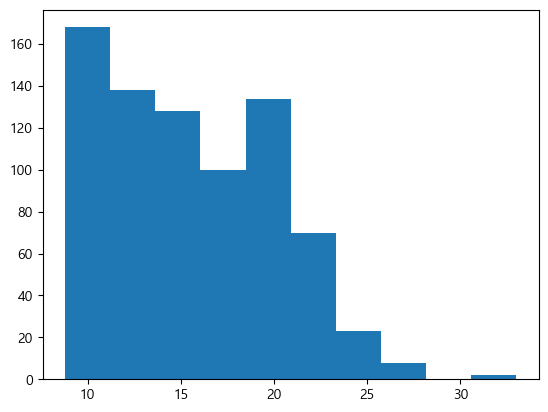

In [101]:
plt.hist(df[df['제품카테고리'] == 'Headgear']['평균금액'])
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_cluster_s = pd.DataFrame(data=scaler.fit_transform(rfm_cluster), columns=rfm_cluster.columns)

In [49]:
rfm_cluster_s

Recency  Frequency  Monetary    평균구매주기     ratio
0    -0.825320   0.489170  2.107010  0.209460 -0.447243
1    -0.687751  -0.424107 -0.355581  0.065554  0.108900
2    -1.238029  -0.304984 -0.383677 -1.462061 -0.205266
3    -0.353653  -0.225569 -0.365229 -0.465791 -0.302603
4    -0.127646  -0.622646 -0.514098 -0.211188 -0.096588
...        ...        ...       ...       ...       ...
1417  0.353847  -0.662353 -0.627527  0.331226 -0.569210
1418  1.248048  -0.622646 -0.519146  1.338567  1.051209
1419 -0.550181   0.012677 -0.170887 -0.554348 -0.330412
1420  0.501243  -0.662353 -0.617245  0.264808  1.557591
1421 -0.599313   1.362739  0.607942 -0.388303 -0.489478

[1422 rows x 5 columns]

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(rfm_cluster_s.iloc[:, :5])
rfm_cluster_s['cluster_result'] = kmeans.labels_
rfm_cluster_s['RFM'] = rfm['Segmentation']


rfm['kmeans'] = rfm_cluster_s['cluster_result']
rfm.groupby('kmeans')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

고객ID     Recency   Frequency      Monetary
kmeans                                            
2          6   80.833333  270.666667  62299.016383
4        177   78.757062   55.768362  11383.969508
1        720   84.461111   13.744444   2464.887226
0        482  251.682573   10.653527   1936.013319
3         37  183.351351    1.027027    240.524768

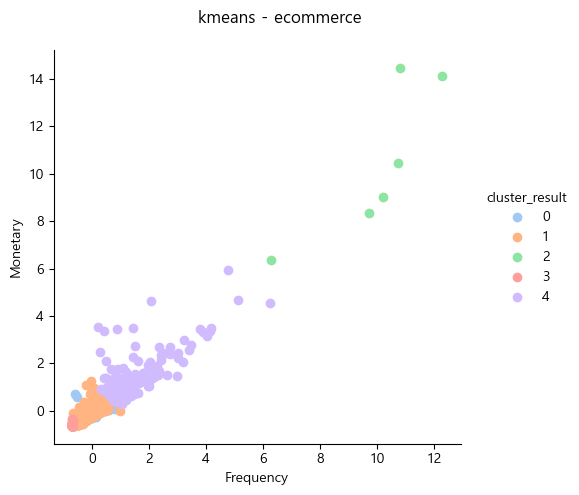

In [51]:
g = sns.FacetGrid(rfm_cluster_s, hue="cluster_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "Frequency", "Monetary")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans - ecommerce")
g.set_xlabels("Frequency")
g.set_ylabels("Monetary")

In [52]:
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
df_centroids['size'] = rfm.groupby('kmeans')['고객ID'].count()

import plotly.graph_objects as go

def plot_radar_from_centroid(df_centroids):
  df_centroids = df_centroids.drop(['size'], axis = 1)
  fig = go.Figure()
  categories = df_centroids.columns
  for row in df_centroids.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1].tolist(),
        theta=categories,
        fill='toself',
        name='cluster {}'.format(row[0])
    ))

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,
  )
  fig.show()

plot_radar_from_centroid(df_centroids)  

In [53]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
silhouette_avg

0.36173768290430375

In [54]:
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rfm_cluster_s.iloc[:, :5])
    silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 3 -> silhouette index 0.34799942606093714
k = 4 -> silhouette index 0.3628607102215092
k = 5 -> silhouette index 0.3619692048368809
k = 6 -> silhouette index 0.31432348292967005


k = 7 -> silhouette index 0.3059949303883035
k = 8 -> silhouette index 0.32099316284975493


In [55]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 2)
df_pca = pd.DataFrame(data=pca.fit_transform(rfm_cluster_s.iloc[:, :5]), columns=['pca1', 'pca2'])

kmeans_pca = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_pca)

df_pca['cluster_pca_result'] = kmeans_pca.labels_
rfm['cluster_pca_result'] = kmeans_pca.labels_

rfm.groupby('cluster_pca_result')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

고객ID     Recency   Frequency      Monetary
cluster_pca_result                                            
4                      6   80.833333  270.666667  62299.016383
2                    187   82.288770   54.695187  11126.457164
3                    484   57.274793   13.710744   2516.801414
0                    499  171.607214   11.737475   1992.807453
1                    246  301.243902    9.020325   1782.719304

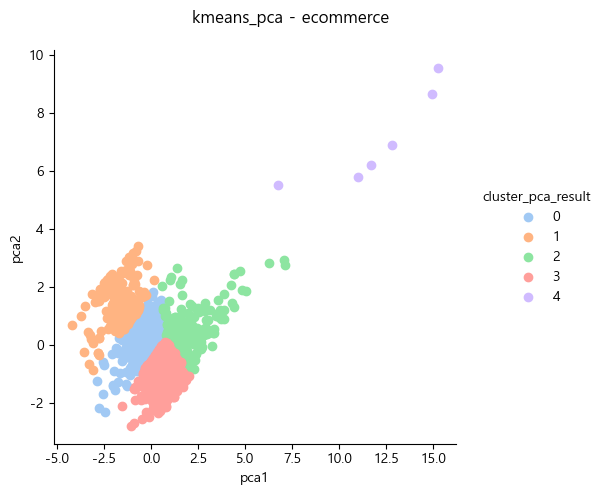

In [56]:
g = sns.FacetGrid(df_pca, hue="cluster_pca_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "pca1", "pca2")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans_pca - ecommerce")
g.set_xlabels("pca1")
g.set_ylabels("pca2")

In [57]:
# df_centroids = pd.DataFrame(kmeans_pca.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
# df_centroids['size'] = rfm.groupby('cluster_pca_result')['고객ID'].count()

# import plotly.graph_objects as go

# def plot_radar_from_centroid(df_centroids):
#   df_centroids = df_centroids.drop(['size'], axis = 1)
#   fig = go.Figure()
#   categories = df_centroids.columns
#   for row in df_centroids.iterrows():
#     fig.add_trace(go.Scatterpolar(
#         r=row[1].tolist(),
#         theta=categories,
#         fill='toself',
#         name='cluster {}'.format(row[0])
#     ))

#   fig.update_layout(
#       autosize=False,
#       width=1000,
#       height=800,
#   )
#   fig.show()

# plot_radar_from_centroid(df_centroids)  

### 2. t-SNE

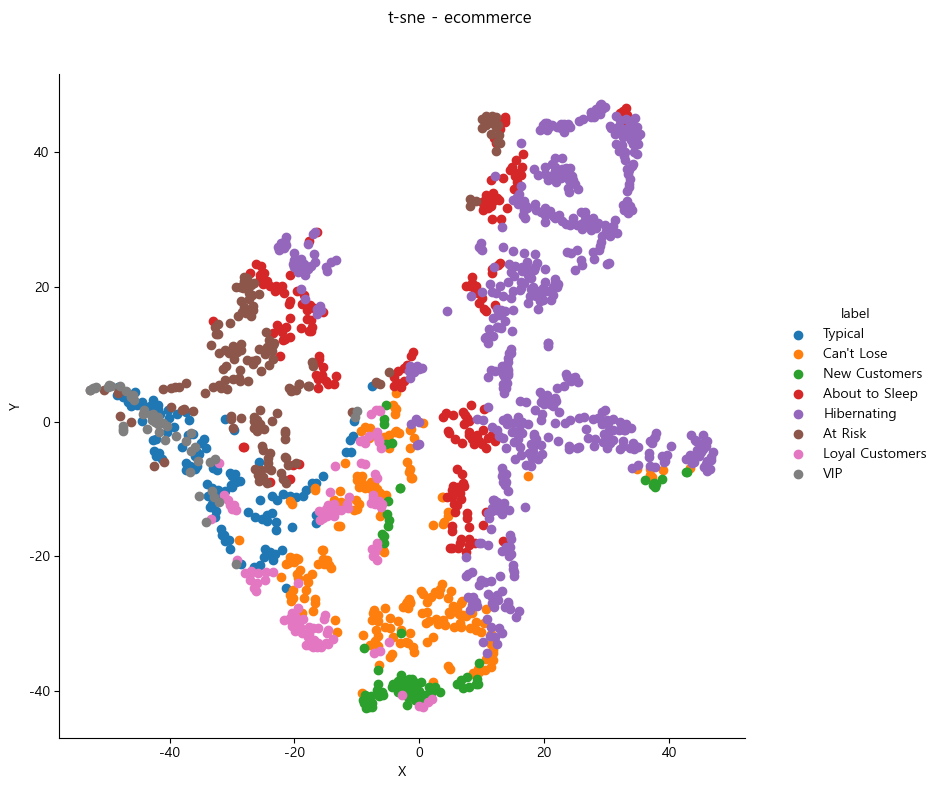

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']

h = sns.FacetGrid(df_ecommerce_tsne, hue="label", height = 8, margin_titles = True,
                  palette = sns.color_palette())
h.map_dataframe(plt.scatter, "col1", "col2")
h.add_legend()
h.fig.subplots_adjust(top=0.9)
h.fig.suptitle("t-sne - ecommerce")
h.set_xlabels("X")
h.set_ylabels("Y")

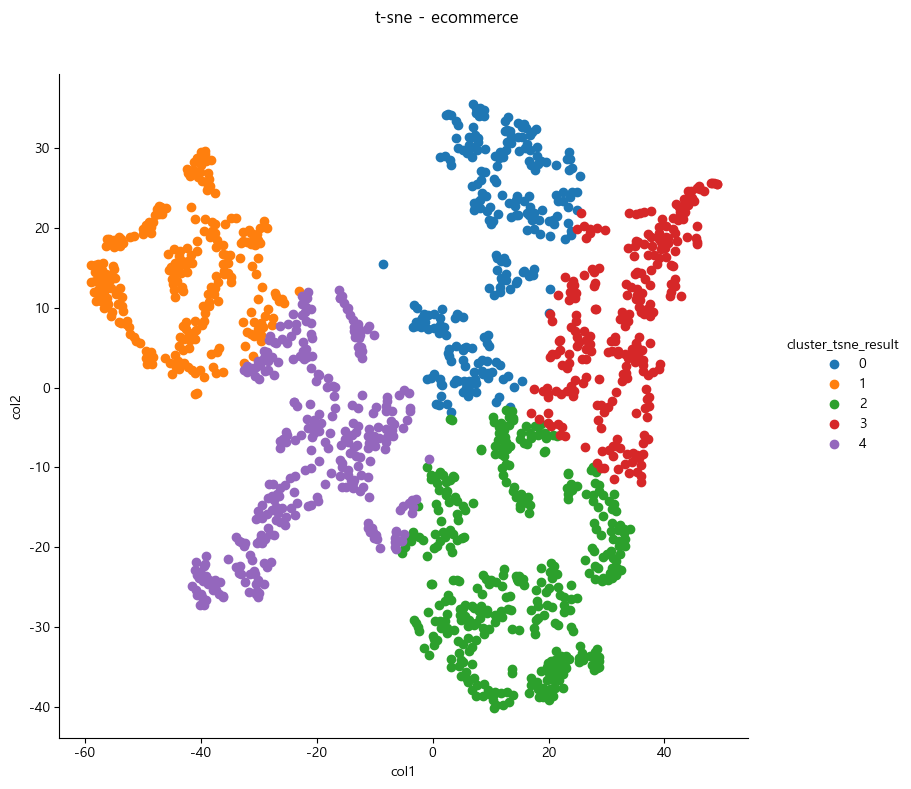

In [59]:


tsne_2 = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']


kmeans_tsne = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_ecommerce_tsne[['col1', 'col2']])
df_ecommerce_tsne['cluster_tsne_result'] = kmeans_tsne.labels_



i = sns.FacetGrid(df_ecommerce_tsne, hue="cluster_tsne_result", height = 8, margin_titles = True,
                  palette = sns.color_palette())
i.map_dataframe(plt.scatter, "col1", "col2")
i.add_legend()
i.fig.subplots_adjust(top=0.9)
i.fig.suptitle("t-sne - ecommerce")
i.set_xlabels("col1")
i.set_ylabels("col2")

In [60]:
# df_centroids = pd.DataFrame(kmeans_tsne.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
# df_centroids['size'] = rfm.groupby('cluster_pca_result')['고객ID'].count()

# import plotly.graph_objects as go

# def plot_radar_from_centroid(df_centroids):
#   df_centroids = df_centroids.drop(['size'], axis = 1)
#   fig = go.Figure()
#   categories = df_centroids.columns
#   for row in df_centroids.iterrows():
#     fig.add_trace(go.Scatterpolar(
#         r=row[1].tolist(),
#         theta=categories,
#         fill='toself',
#         name='cluster {}'.format(row[0])
#     ))

#   fig.update_layout(
#       autosize=False,
#       width=1000,
#       height=800,
#   )
#   fig.show()

# plot_radar_from_centroid(df_centroids)  

In [61]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

dend_ecommerce = rfm_cluster_s.iloc[:, :5]

plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('users')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(dend_ecommerce, method = 'ward'))
plt.show()


KeyboardInterrupt: 

In [ ]:
ecommerce_clustering = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
ecommerce_label = ecommerce_clustering.fit_predict(dend_ecommerce)
ecommerce_label

array([1, 3, 0, ..., 0, 4, 3], dtype=int64)

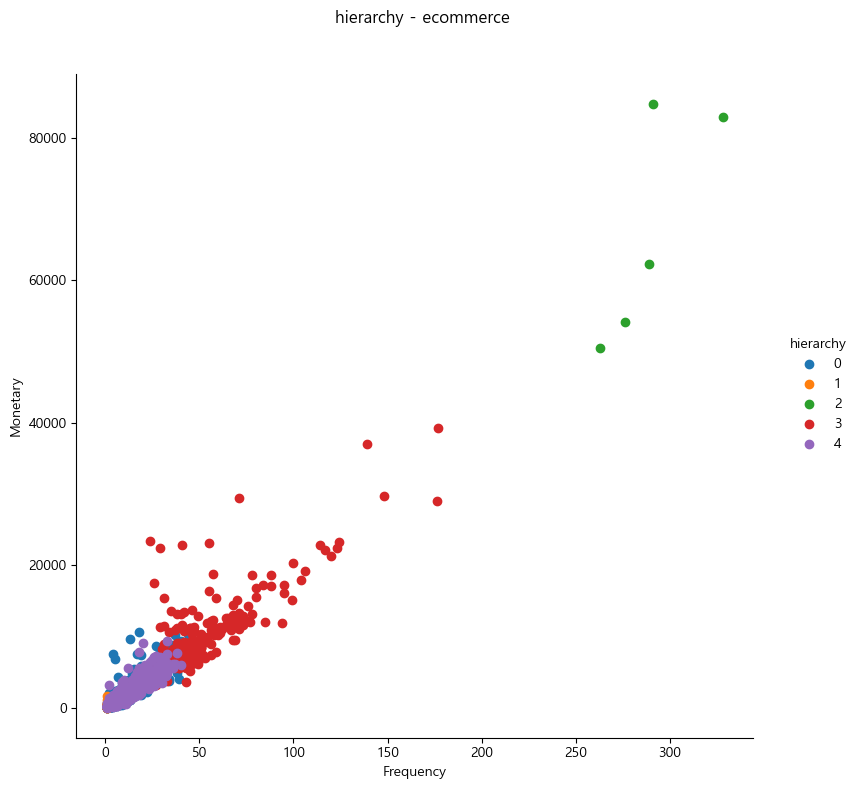

In [ ]:
rfm['hierarchy'] = ecommerce_label

j = sns.FacetGrid(rfm, hue="hierarchy", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "Frequency", "Monetary")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("hierarchy - ecommerce")
j.set_xlabels("Frequency")
j.set_ylabels("Monetary")

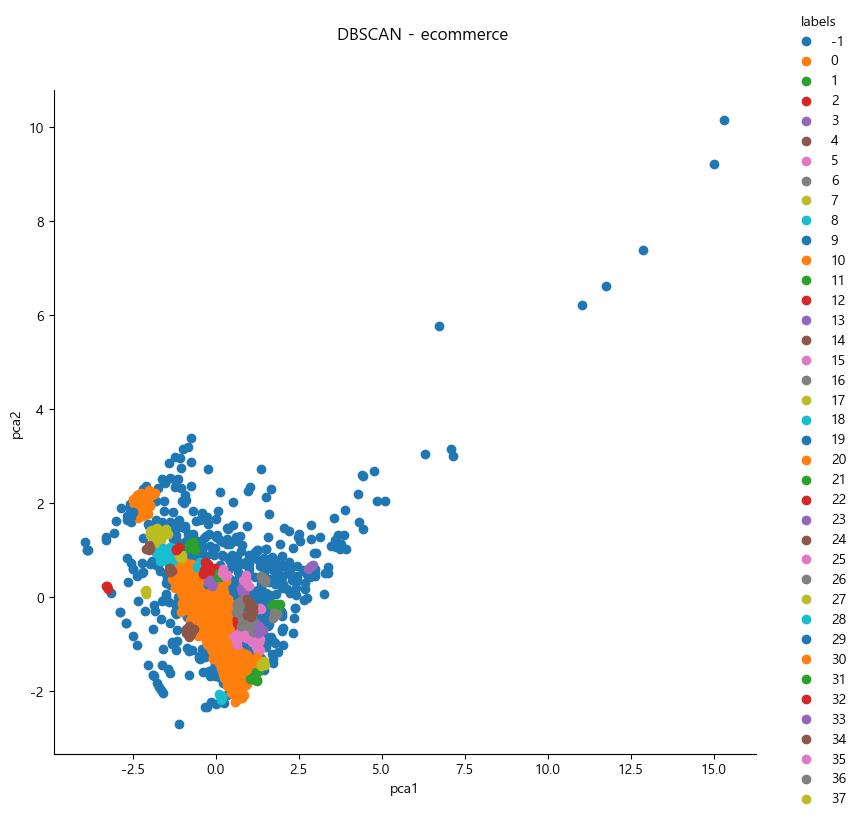

In [ ]:
from sklearn.cluster import DBSCAN



dbscan = DBSCAN(eps=0.1, min_samples=4).fit(df_pca[['pca1', 'pca2']])
y_pred = dbscan.labels_

df_pca['labels'] = y_pred

j = sns.FacetGrid(df_pca, hue="labels", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "pca1", "pca2")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("DBSCAN - ecommerce")
j.set_xlabels("pca1")
j.set_ylabels("pca2")

### EDA

In [ ]:
##### 비즈니스 인사이트 테이블

In [ ]:
#### ROAS 지표

df.head()

고객ID              거래ID       거래날짜          제품ID    제품카테고리  수량    평균금액  \
0  USER_1358  Transaction_0000 2019-01-01  Product_0981  Nest-USA   1  153.71   
1  USER_1358  Transaction_0001 2019-01-01  Product_0981  Nest-USA   1  153.71   
2  USER_1358  Transaction_0002 2019-01-01  Product_0904    Office   1    2.05   
3  USER_1358  Transaction_0003 2019-01-01  Product_0203   Apparel   5   17.53   
4  USER_1358  Transaction_0003 2019-01-01  Product_0848      Bags   1   16.50   

   배송료      쿠폰상태 성별  ...    월    쿠폰코드   할인율 오프라인비용   온라인비용  true_discount  \
0  6.5      Used  남  ...  Jan  ELEC10  10.0   4500  2424.5              1   
1  6.5      Used  남  ...  Jan  ELEC10  10.0   4500  2424.5              1   
2  6.5      Used  남  ...  Jan   OFF10  10.0   4500  2424.5              1   
3  6.5  Not Used  남  ...  Jan  SALE10  10.0   4500  2424.5              0   
4  6.5      Used  남  ...  Jan   AIO10  10.0   4500  2424.5              1   

      평균배송료     납세액         총금액  real_discount  
0  6.500000  15.371  160.210000           10.0  
1  6.500000  15.371  160.210000           10.0  
2  6.500000   0.205    8.550000           10.0  
3  1.083333  15.777  104.510333            0.0  
4  1.083333   2.970   18.903333           10.0  

[5 rows x 23 columns]

In [ ]:
df['총마케팅비용'] = df['오프라인비용'] + df['온라인비용']
df['ma_total_marketing'] = df['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
df

고객ID               거래ID       거래날짜          제품ID    제품카테고리  수량  \
0      USER_1358   Transaction_0000 2019-01-01  Product_0981  Nest-USA   1   
1      USER_1358   Transaction_0001 2019-01-01  Product_0981  Nest-USA   1   
2      USER_1358   Transaction_0002 2019-01-01  Product_0904    Office   1   
3      USER_1358   Transaction_0003 2019-01-01  Product_0203   Apparel   5   
4      USER_1358   Transaction_0003 2019-01-01  Product_0848      Bags   1   
...          ...                ...        ...           ...       ...  ..   
52919  USER_0504  Transaction_25056 2019-12-31  Product_0976  Nest-USA   1   
52920  USER_0504  Transaction_25057 2019-12-31  Product_0413   Apparel   1   
52921  USER_0504  Transaction_25058 2019-12-31  Product_0989  Nest-USA   1   
52922  USER_0562  Transaction_25059 2019-12-31  Product_0985  Nest-USA   5   
52923  USER_0562  Transaction_25060 2019-12-31  Product_0984  Nest-USA   4   

         평균금액    배송료      쿠폰상태 성별  ...   할인율  오프라인비용    온라인비용 true_discount  \
0      153.71   6.50      Used  남  ...  10.0    4500  2424.50             1   
1      153.71   6.50      Used  남  ...  10.0    4500  2424.50             1   
2        2.05   6.50      Used  남  ...  10.0    4500  2424.50             1   
3       17.53   6.50  Not Used  남  ...  10.0    4500  2424.50             0   
4       16.50   6.50      Used  남  ...  10.0    4500  2424.50             1   
...       ...    ...       ... ..  ...   ...     ...      ...           ...   
52919  121.30   6.50   Clicked  여  ...  30.0    4000  2058.75             0   
52920   48.92   6.50      Used  여  ...  30.0    4000  2058.75             1   
52921  151.88   6.50      Used  여  ...  30.0    4000  2058.75             1   
52922   80.52   6.50   Clicked  여  ...  30.0    4000  2058.75             0   
52923   80.52  19.99   Clicked  여  ...  30.0    4000  2058.75             0   

           평균배송료      납세액         총금액  real_discount   총마케팅비용  \
0       6.500000  15.3710  160.210000           10.0  6924.50   
1       6.500000  15.3710  160.210000           10.0  6924.50   
2       6.500000   0.2050    8.550000           10.0  6924.50   
3       1.083333  15.7770  104.510333            0.0  6924.50   
4       1.083333   2.9700   18.903333           10.0  6924.50   
...          ...      ...         ...            ...      ...   
52919   6.500000  12.1300  139.930000            0.0  6058.75   
52920   6.500000   8.8056   49.549600           30.0  6058.75   
52921   6.500000  15.1880  128.004000           30.0  6058.75   
52922   6.500000  40.2600  449.360000            0.0  6058.75   
52923  19.990000  32.2080  374.278000            0.0  6058.75   

       ma_total_marketing  
0                 6924.50  
1                 6924.50  
2                 6924.50  
3                 6924.50  
4                 6924.50  
...                   ...  
52919             6058.75  
52920             6058.75  
52921             6058.75  
52922             6058.75  
52923             6058.75  

[52924 rows x 25 columns]

In [ ]:
marketing = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)

marketing2 = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)
marketing2['ma_total_marketing'] = marketing2['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
marketing2 = marketing2.rename(columns={'ma_total_marketing':'총마케팅비용(7일ma)'})
marketing2

거래날짜   총마케팅비용  총마케팅비용(7일ma)
0   2019-01-01  6924.50   7477.351429
1   2019-01-02  7980.36   7477.351429
2   2019-01-03  6076.38   7477.351429
3   2019-01-04  7428.55   7477.351429
4   2019-01-05  8555.30   7477.351429
..         ...      ...           ...
360 2019-12-27  7396.87   6754.795714
361 2019-12-28  7246.84   6702.525714
362 2019-12-29  6546.58   6664.971429
363 2019-12-30  4674.31   6375.631429
364 2019-12-31  6058.75   6134.101429

[365 rows x 3 columns]

In [ ]:
sales = df.groupby('거래날짜')['총금액'].sum().reset_index()
sales

거래날짜         총금액
0   2019-01-01   8389.5816
1   2019-01-02  14967.0770
2   2019-01-03  27206.2101
3   2019-01-04  18768.6781
4   2019-01-05  20104.2152
..         ...         ...
360 2019-12-27  14209.5811
361 2019-12-28  11014.3226
362 2019-12-29  12276.2817
363 2019-12-30   8397.3965
364 2019-12-31  10716.6735

[365 rows x 2 columns]

In [ ]:
roas1 = pd.merge(marketing, sales, how='left', on='거래날짜')
roas1['ratio'] = roas1['총금액'] / roas1['총마케팅비용']
roas1.sort_values('ratio', ascending=False).head(10)

거래날짜   총마케팅비용         총금액      ratio
150 2019-05-31  1510.30  23770.4291  15.738879
29  2019-01-30  1681.86  21349.3265  12.693879
94  2019-04-05  4842.68  59088.7803  12.201669
151 2019-06-01   820.25   9678.5838  11.799554
31  2019-02-01  1392.67  16000.5043  11.489085
23  2019-01-24  1560.02  16505.0998  10.580057
213 2019-08-02  3655.96  37909.3386  10.369189
30  2019-01-31  2080.14  21020.9349  10.105539
149 2019-05-30  1762.38  17584.7791   9.977859
107 2019-04-18  5476.58  53397.6890   9.750189

In [ ]:
roas2 = pd.merge(marketing2, sales, how='left', on='거래날짜')
roas2['ratio'] = roas2['총금액'] / roas2['총마케팅비용(7일ma)']
roas2.sort_values('ratio', ascending=False).head(10)


거래날짜   총마케팅비용  총마케팅비용(7일ma)         총금액      ratio
94  2019-04-05  4842.68   4289.407143  59088.7803  13.775512
29  2019-01-30  1681.86   1788.870000  21349.3265  11.934532
213 2019-08-02  3655.96   3241.630000  37909.3386  11.694530
30  2019-01-31  2080.14   1863.172857  21020.9349  11.282332
330 2019-11-27  5819.58   5001.338571  55439.0730  11.084847
150 2019-05-31  1510.30   2243.272857  23770.4291  10.596316
198 2019-07-18  4408.61   3999.448571  41761.8631  10.441905
107 2019-04-18  5476.58   5430.738571  53397.6890   9.832491
31  2019-02-01  1392.67   1758.561429  16000.5043   9.098633
32  2019-02-02  1470.87   1691.888571  13779.3542   8.144363

<AxesSubplot:xlabel='거래날짜', ylabel='ratio'>

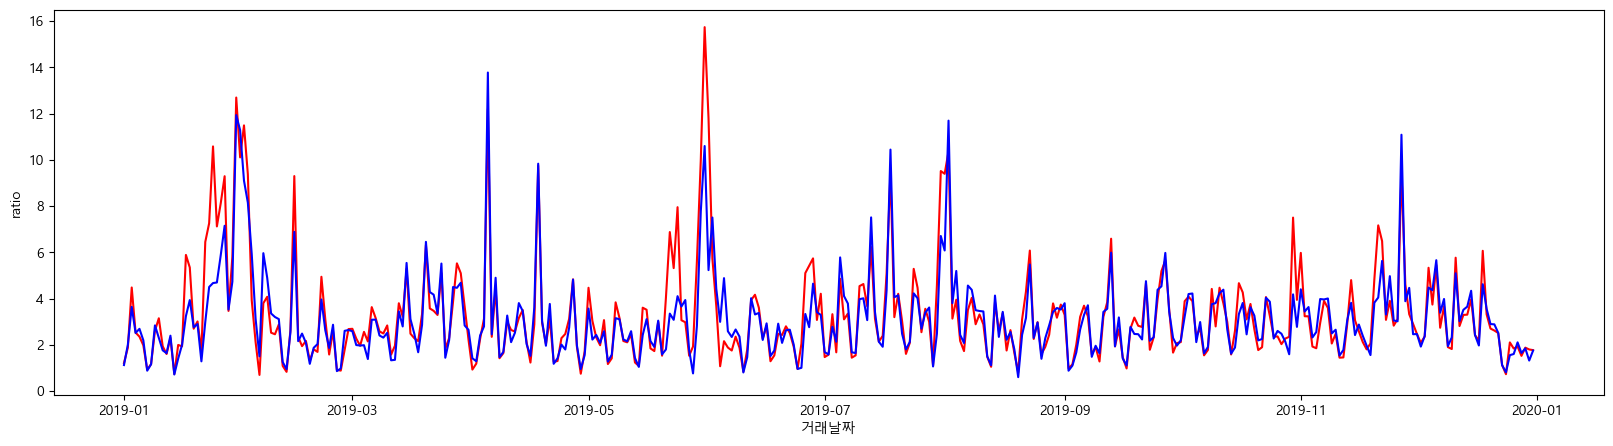

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=roas1, x='거래날짜', y='ratio', color='red')
sns.lineplot(data=roas2, x='거래날짜', y='ratio', color='blue')


# ratio(빨강) = 총비용 / 총마케팅비용
# ratio(파랑) = 총비용 / 총마케팅비용(이동평균)

# 총마케팅비용(이동평균) - 원본의 고점을 낮게 만드는 효과

# 마케팅의 특성상 직관적으로 볼때는 이동평균을 하는게 맞아보이는데


In [ ]:
week = []
cut = 0


for i in range(1, 54):
    for j in range(7):
        week.append(i)
        if len(week) == len(roas1):
            break
    if len(week) == len(roas1):
        break

roas1['week'] = np.array(week).reshape(len(roas1), -1)
roas1

거래날짜   총마케팅비용         총금액     ratio  week
0   2019-01-01  6924.50   8389.5816  1.211579     1
1   2019-01-02  7980.36  14967.0770  1.875489     1
2   2019-01-03  6076.38  27206.2101  4.477371     1
3   2019-01-04  7428.55  18768.6781  2.526560     1
4   2019-01-05  8555.30  20104.2152  2.349914     1
..         ...      ...         ...       ...   ...
360 2019-12-27  7396.87  14209.5811  1.921026    52
361 2019-12-28  7246.84  11014.3226  1.519879    52
362 2019-12-29  6546.58  12276.2817  1.875221    52
363 2019-12-30  4674.31   8397.3965  1.796500    52
364 2019-12-31  6058.75  10716.6735  1.768793    53

[365 rows x 5 columns]

In [ ]:
week_core = pd.DataFrame(roas1.groupby('week')[['총마케팅비용', '총금액']].sum()).reset_index()
week_core['ratio_week'] = week_core['총금액'] / week_core['총마케팅비용']
week_core.sort_values('ratio_week', ascending=False).head(10)

week    총마케팅비용          총금액  ratio_week
21    22  10081.86   77987.7588    7.735453
3      4  13710.42  100285.4809    7.314545
4      5  13870.26   98204.4768    7.080219
30    31  21959.29  127391.8228    5.801272
28    29  28218.83  117955.2384    4.180019
46    47  33355.78  137593.1222    4.125016
47    48  37320.98  152192.1311    4.077924
20    21  18022.79   72792.0879    4.038891
13    14  31863.55  126414.3853    3.967367
11    12  26066.40  101540.6453    3.895461

<AxesSubplot:xlabel='week', ylabel='총마케팅비용'>

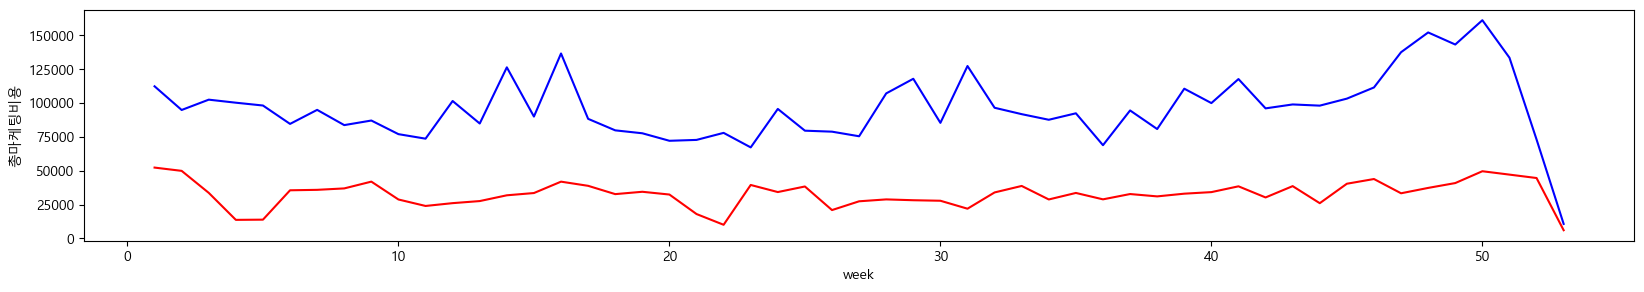

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='총마케팅비용', color='red')
sns.lineplot(data=week_core, x='week', y='총금액', color='blue')


<AxesSubplot:xlabel='week', ylabel='ratio_week'>

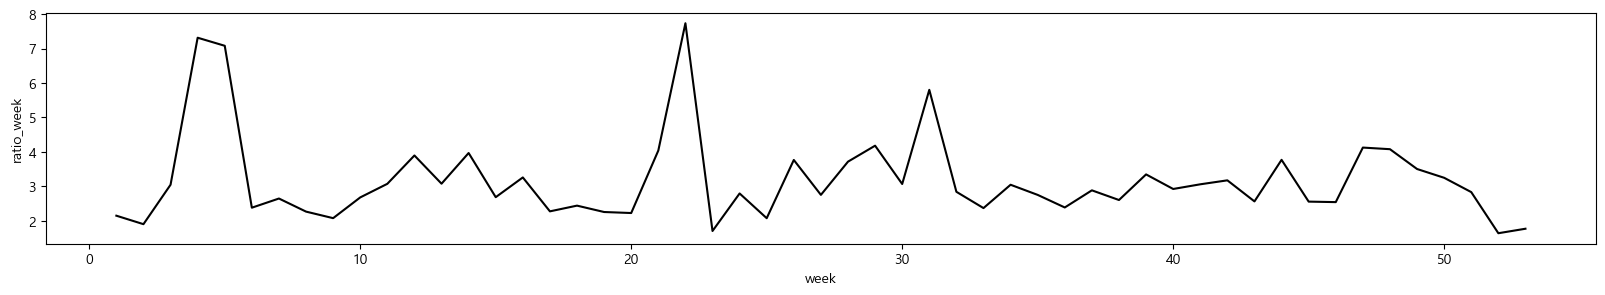

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='ratio_week', color='black')